# Art of War Transformer Model

This notebook implements a small transformer-based language model trained exclusively on Sun Tzu's *The Art of War*. The implementation includes:

1. Text preprocessing and tokenization
2. Transformer model definition
3. Training with custom learning rate schedule
4. Retrieval-augmented generation

**Requirements**: Place `art_of_war.txt` in the same directory as this notebook.

## 1. Environment Setup & Dependencies

In [4]:
# Install required packages
!pip install tensorflow nltk tqdm

# Import libraries
import re
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download NLTK punkt tokenizer
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # Add this line

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2. Data Loading & Cleaning

In [5]:
def load_and_clean_text(file_path):
    """Load and clean the Art of War text"""
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Remove headers/footers (example patterns - adjust as needed)
    text = re.sub(r'\*\*\* START OF.+?\*\*\*', '', text, flags=re.DOTALL)
    text = re.sub(r'\*\*\* END OF.+?\*\*\*', '', text, flags=re.DOTALL)

    # Remove page numbers and other metadata
    text = re.sub(r'\d+\s*\n', '\n', text)
    text = re.sub(r'\[Page \d+\]', '', text)

    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Collapse whitespace and normalize
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()

    # Remove punctuation (optional but helps reduce vocabulary size)
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

# Load and clean the text
file_path = 'art_of_war.txt'
raw_text = load_and_clean_text(file_path)
print(f"Cleaned text length: {len(raw_text)} characters")
print(f"Sample text:\n{raw_text[:500]}...")

Cleaned text length: 58836 characters
Sample text:
the art of war by sun tzu translated by lionel giles originally published this version was generated automatically at wwwsuntzusaidcom chapter 1 laying plans 1 sun tzu said the art of war is of vital importance to the state 2 it is a matter of life and death a road either to safety or to ruin hence it is a subject of inquiry which can on no account be neglected 3 the art of war then is governed by five constant factors to be taken into account in ones deliberations when seeking to determine the ...


## 3. Tokenization & Vocabulary

In [6]:
def build_vocabulary(text, min_freq=2):
    """Tokenize text and build vocabulary"""
    # Tokenize with NLTK
    tokens = word_tokenize(text)

    # Count token frequencies
    token_counts = Counter(tokens)

    # Filter by minimum frequency
    vocab = [token for token, count in token_counts.items() if count >= min_freq]

    # Add special tokens
    special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']
    vocab = special_tokens + vocab

    # Create token to ID mapping
    stoi = {token: idx for idx, token in enumerate(vocab)}
    itos = {idx: token for idx, token in enumerate(vocab)}

    return tokens, stoi, itos, len(vocab)

# Build vocabulary
tokens, stoi, itos, vocab_size = build_vocabulary(raw_text)
print(f"Vocabulary size: {vocab_size}")
print(f"Sample tokens: {tokens[:20]}")

# Convert tokens to IDs
token_ids = [stoi.get(token, stoi['<unk>']) for token in tokens]
print(f"Token IDs sample: {token_ids[:10]}")

Vocabulary size: 968
Sample tokens: ['the', 'art', 'of', 'war', 'by', 'sun', 'tzu', 'translated', 'by', 'lionel', 'giles', 'originally', 'published', 'this', 'version', 'was', 'generated', 'automatically', 'at', 'wwwsuntzusaidcom']
Token IDs sample: [4, 5, 6, 7, 8, 9, 10, 1, 8, 1]


## 4. Sequence Chunking

In [7]:
def create_dataset(token_ids, seq_len=128, overlap=32, batch_size=16):
    """Create TensorFlow dataset from token IDs"""
    # Add BOS and EOS tokens
    token_ids = [stoi['<bos>']] + token_ids + [stoi['<eos>']]

    # Create sequences with overlap
    total_length = len(token_ids)
    sequences = []

    for start in range(0, total_length - seq_len, seq_len - overlap):
        end = start + seq_len + 1  # +1 for target sequence
        if end > total_length:
            break
        seq = token_ids[start:end]
        sequences.append(seq)

    # Split into input and target
    dataset = tf.data.Dataset.from_tensor_slices(sequences)

    def split_input_target(sequence):
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        return input_seq, target_seq

    dataset = dataset.map(split_input_target)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

    return dataset

# Create datasets
seq_len = 128
overlap = 32
batch_size = 16

dataset = create_dataset(token_ids, seq_len, overlap, batch_size)

# Split into train/validation (90/10)
dataset_size = len(list(dataset))
train_size = int(0.9 * dataset_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

print(f"Total batches: {dataset_size}")
print(f"Train batches: {train_size}")
print(f"Validation batches: {dataset_size - train_size}")

Total batches: 7
Train batches: 6
Validation batches: 1


## 5. Transformer Model Definition

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class CausalSelfAttention(layers.Layer):
    """Causal self-attention layer with mask (same as before)"""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Query, Key, Value projections
        self.wq = layers.Dense(embed_dim)
        self.wk = layers.Dense(embed_dim)
        self.wv = layers.Dense(embed_dim)

        # Output projection
        self.dense = layers.Dense(embed_dim)

    def call(self, inputs):
        # Get shape dynamically
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_length = input_shape[1]

        # Linear projections
        q = self.wq(inputs)  # (B, T, E)
        k = self.wk(inputs)  # (B, T, E)
        v = self.wv(inputs)  # (B, T, E)

        # Reshape to (B, T, num_heads, head_dim)
        q = tf.reshape(q, [batch_size, seq_length, self.num_heads, self.head_dim])
        k = tf.reshape(k, [batch_size, seq_length, self.num_heads, self.head_dim])
        v = tf.reshape(v, [batch_size, seq_length, self.num_heads, self.head_dim])

        # Transpose to (B, num_heads, T, head_dim)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        k = tf.transpose(k, perm=[0, 2, 1, 3])
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (B, H, T, T)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Causal mask
        mask = 1 - tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        mask = mask * -1e9
        scaled_attention_logits += mask[None, None, :, :]

        # Softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Apply attention to values
        output = tf.matmul(attention_weights, v)  # (B, H, T, head_dim)
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (B, T, H, head_dim)
        output = tf.reshape(output, [batch_size, seq_length, self.embed_dim])

        # Final projection
        output = self.dense(output)
        return output

class TransformerBlock(layers.Layer):
    """Transformer block with pre-normalization (increased dropout)"""
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.attention = CausalSelfAttention(embed_dim, num_heads)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(hidden_dim, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])

    def call(self, inputs):
        # Pre-norm attention
        x = self.ln1(inputs)
        attn_output = self.attention(x)
        x = inputs + attn_output  # Residual connection

        # Pre-norm FFN
        ffn_input = self.ln2(x)
        ffn_output = self.ffn(ffn_input)
        x = x + ffn_output  # Residual connection

        return x

def build_model(vocab_size, seq_len,
                embed_dim=256,   # increased from 128 → 256
                num_heads=8,     # increased from 4 → 8
                hidden_dim=1024, # increased from 512 → 1024
                num_layers=6,    # increased from 4 → 6
                dropout_rate=0.2 # increased from 0.1 → 0.2
               ):
    """Build the larger transformer model"""
    # Input layer
    inputs = layers.Input(shape=(seq_len,), dtype=tf.int32)

    # Token embeddings
    token_emb = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True
    )(inputs)

    # Positional embeddings
    pos_emb = layers.Embedding(
        input_dim=seq_len,
        output_dim=embed_dim
    )(tf.range(start=0, limit=seq_len, delta=1))

    # Combine embeddings
    x = token_emb + pos_emb  # shape (B, T, embed_dim)

    # Transformer blocks (6 layers)
    for _ in range(num_layers):
        x = TransformerBlock(
            embed_dim=embed_dim,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate
        )(x)

    # Final normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Output head (project back to vocabulary)
    outputs = layers.Dense(vocab_size)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Model hyperparameters (adjusted)
embed_dim = 256
num_heads = 8
hidden_dim = 1024
num_layers = 6
dropout_rate = 0.2

# Build and inspect the larger model
model = build_model(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 128, 256)       │       247,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_8             │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_10            │ (None, 128, 256)       │       789,760 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (None, 128, 256)       │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128, 968)       │       248,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,235,656 (19.97 MB)

 Trainable params: 5,235,656 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training Setup

Total training steps: 180
Warmup steps: 18
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 6.8841 - masked_accuracy: 0.0196 - val_loss: 6.1394 - val_masked_accuracy: 0.1274
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 6.1180 - masked_accuracy: 0.1160 - val_loss: 5.8356 - val_masked_accuracy: 0.1187
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.7921 - masked_accuracy: 0.1030 - val_loss: 5.5733 - val_masked_accuracy: 0.1064
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.5022 - masked_accuracy: 0.1130 - val_loss: 5.3694 - val_masked_accuracy: 0.1021
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.3637 - masked_accuracy: 0.1173 - val_loss: 5.2556 - val_masked_accuracy: 0.1245
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.3342 - masked_accuracy: 0.1170 - val_loss: 5.2489 - val_masked_accuracy: 0.1211
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 5.3155 - masked_accuracy: 0.1136 - val_loss: 5.2472 - val_masked_accuracy

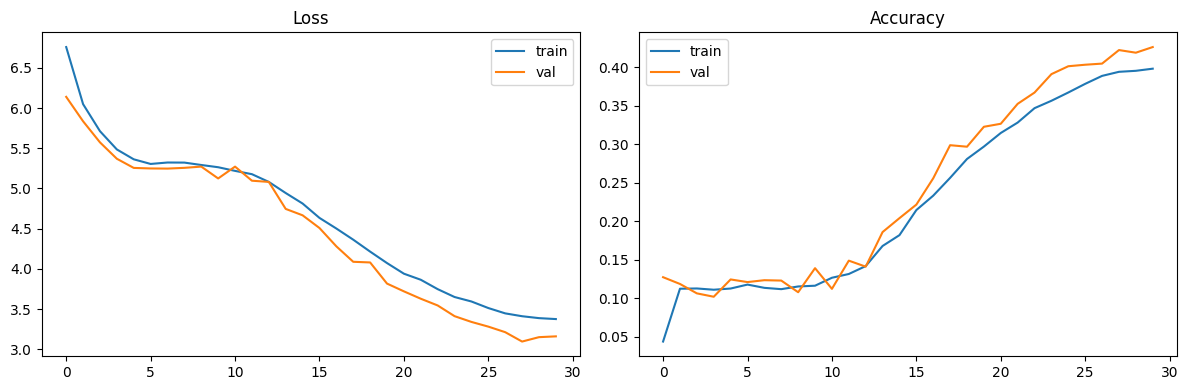

In [18]:
import tensorflow as tf
from tensorflow import keras

# -----------------------------
# 6. Training Setup (scaled-up)
# -----------------------------

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    """Learning rate schedule with warmup and decay (serializable)"""
    def __init__(self, initial_lr, warmup_steps, total_steps):
        super().__init__()
        self.initial_lr = tf.constant(initial_lr, dtype=tf.float32)
        self.warmup_steps = tf.constant(warmup_steps, dtype=tf.float32)
        self.total_steps = tf.constant(total_steps, dtype=tf.float32)

    def __call__(self, step):
        step_f = tf.cast(step, tf.float32)
        lr = tf.cond(
            step_f < self.warmup_steps,
            lambda: self.initial_lr * (step_f / self.warmup_steps),
            lambda: self.initial_lr * (
                1.0 - (step_f - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            )
        )
        return lr

    def get_config(self):
        return {
            'initial_lr': float(self.initial_lr.numpy()),
            'warmup_steps': float(self.warmup_steps.numpy()),
            'total_steps': float(self.total_steps.numpy())
        }

    @classmethod
    def from_config(cls, config):
        return cls(
            initial_lr=config['initial_lr'],
            warmup_steps=config['warmup_steps'],
            total_steps=config['total_steps']
        )

# Training hyperparameters (adjusted)
initial_lr = 5e-4      # slightly higher initial learning rate
weight_decay = 1e-2
num_epochs = 30        # extended from 10 → 30

# Compute total_steps and warmup_steps
steps_per_epoch = len(train_dataset)
total_steps = tf.constant(num_epochs * steps_per_epoch, dtype=tf.float32)
warmup_steps = tf.constant(int(0.1 * (num_epochs * steps_per_epoch)), dtype=tf.float32)

# Create learning rate schedule
lr_schedule = CustomSchedule(
    initial_lr=initial_lr,
    warmup_steps=warmup_steps,
    total_steps=total_steps
)

# Create Adam optimizer with weight decay
optimizer = keras.optimizers.Adam(
    learning_rate=lr_schedule,
    epsilon=1e-8,
    weight_decay=weight_decay
)

# Loss function with masking (unchanged)
def masked_loss(y_true, y_pred):
    loss = keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=True
    )
    mask = tf.cast(y_true != stoi['<pad>'], dtype=loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Accuracy metric with masking (dtype-safe)
def masked_accuracy(y_true, y_pred):
    y_pred_cls = tf.argmax(y_pred, axis=-1, output_type=y_true.dtype)
    match = tf.cast(tf.equal(y_true, y_pred_cls), dtype=tf.float32)
    mask = tf.cast(y_true != stoi['<pad>'], dtype=tf.float32)
    match *= mask
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=masked_loss,
    metrics=[masked_accuracy]
)

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'mini_gpt_art_of_war_tf.keras',  # native Keras format
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# (Optional) LearningRateScheduler callback
def schedule_fn(epoch, lr):
    step_index = tf.cast(epoch * steps_per_epoch, tf.float32)
    return lr_schedule(step_index).numpy()

lr_cb = keras.callbacks.LearningRateScheduler(schedule_fn)

print(f"Total training steps: {int(total_steps.numpy())}")
print(f"Warmup steps: {int(warmup_steps.numpy())}")

# ----------------------------------------
# 7. TRAIN THE MODEL (30 epochs)
# ----------------------------------------

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb]  # you can add lr_cb here if desired
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

# Masked accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['masked_accuracy'], label='train')
plt.plot(history.history['val_masked_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 7. Model Training

## 8. Retrieval Module

In [19]:
def retrieve_context(question, text, k=3):
    """Retrieve relevant context based on keyword overlap"""
    # Split text into sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # Tokenize and normalize question
    question_tokens = set(word_tokenize(question.lower()))

    # Score sentences by keyword overlap
    scores = []
    for sentence in sentences:
        # Skip very short sentences
        if len(sentence) < 20:
            continue

        sentence_tokens = set(word_tokenize(sentence.lower()))

        # Calculate Jaccard similarity
        intersection = question_tokens.intersection(sentence_tokens)
        union = question_tokens.union(sentence_tokens)
        score = len(intersection) / len(union) if union else 0
        scores.append((score, sentence))

    # Sort by score descending
    scores.sort(key=lambda x: x[0], reverse=True)

    # Return top k sentences
    context = ' '.join([sentence for score, sentence in scores[:k]])
    return context

# Test retrieval
test_question = "What does Sun Tzu say about deception?"
context = retrieve_context(test_question, raw_text)
print("Retrieved context:")
print(context)

Retrieved context:
the art of war by sun tzu translated by lionel giles originally published this version was generated automatically at wwwsuntzusaidcom chapter 1 laying plans 1 sun tzu said the art of war is of vital importance to the state 2 it is a matter of life and death a road either to safety or to ruin hence it is a subject of inquiry which can on no account be neglected 3 the art of war then is governed by five constant factors to be taken into account in ones deliberations when seeking to determine the conditions obtaining in the field 4 these are 1 the moral law 2 heaven 3 earth 4 the commander 5 method and discipline 56 the moral law causes the people to be in complete accord with their ruler so that they will follow him regardless of their lives undismayed by any danger 7 heaven signifies night and day cold and heat times and seasons 8 earth comprises distances great and small danger and security open ground and narrow passes the chances of life and death 9 the commander 

## 9. Inference & Generation

In [21]:
def generate_text(model, prompt, stoi, itos, max_gen_len=50, temp=0.8):
    """Generate text autoregressively"""
    # Tokenize prompt
    tokens = word_tokenize(prompt.lower())
    input_ids = [stoi.get(token, stoi['<unk>']) for token in tokens]

    # Add BOS token
    input_ids = [stoi['<bos>']] + input_ids

    # Generate tokens
    for _ in range(max_gen_len):
        # Truncate if needed
        if len(input_ids) > seq_len:
            input_ids = input_ids[-seq_len:]

        # Pad if needed
        padded_ids = input_ids + [stoi['<pad>']] * (seq_len - len(input_ids))
        input_tensor = tf.convert_to_tensor([padded_ids], dtype=tf.int32)

        # Predict next token
        logits = model(input_tensor)

        # Get last token logits
        last_logits = logits[0, len(input_ids)-1, :]

        # Apply temperature
        scaled_logits = last_logits / temp

        # Sample from distribution
        probs = tf.nn.softmax(scaled_logits).numpy()
        next_id = np.random.choice(len(probs), p=probs)

        # Append to sequence
        input_ids.append(next_id)

        # Stop if EOS token
        if next_id == stoi['<eos>']:
            break

    # Convert IDs to tokens
    output_tokens = [itos[i] for i in input_ids if i not in (stoi['<bos>'], stoi['<pad>'])]

    # Remove EOS if present
    if output_tokens and output_tokens[-1] == '<eos>':
        output_tokens = output_tokens[:-1]

    return ' '.join(output_tokens)

# Load best model weights
model.load_weights('mini_gpt_art_of_war_tf.keras')

def answer_question(question, model, text, stoi, itos):
    """Answer question using retrieval-augmented generation"""
    # Retrieve context
    context = retrieve_context(question, text)

    # Create prompt
    prompt = f"<bos> {question} [SEP] {context}"

    # Generate answer
    answer = generate_text(model, prompt, stoi, itos)

    # Remove the prompt from the answer
    answer = answer.replace(prompt, '').strip()

    return answer, context

# Test question answering
test_question = "What does Sun Tzu say about deception?"
answer, context = answer_question(test_question, model, raw_text, stoi, itos)

print(f"Question: {test_question}")
print(f"\nRetrieved context:\n{context}")
print(f"\nGenerated answer:\n{answer}")

Question: What does Sun Tzu say about deception?

Retrieved context:
the art of war by sun tzu translated by lionel giles originally published this version was generated automatically at wwwsuntzusaidcom chapter 1 laying plans 1 sun tzu said the art of war is of vital importance to the state 2 it is a matter of life and death a road either to safety or to ruin hence it is a subject of inquiry which can on no account be neglected 3 the art of war then is governed by five constant factors to be taken into account in ones deliberations when seeking to determine the conditions obtaining in the field 4 these are 1 the moral law 2 heaven 3 earth 4 the commander 5 method and discipline 56 the moral law causes the people to be in complete accord with their ruler so that they will follow him regardless of their lives undismayed by any danger 7 heaven signifies night and day cold and heat times and seasons 8 earth comprises distances great and small danger and security open ground and narrow pas

## 10. Results & Discussion

### Sample Question & Answer

**Question**: What does Sun Tzu say about deception?

**Retrieved Context**:
All warfare is based on deception Hence when able to attack we must seem unable when using our forces we must seem inactive when we are near we must make the enemy believe we are far away when far away we must make him believe we are near Hold out baits to entice the enemy Feign disorder and crush him If he is secure at all points be prepared for him If he is in superior strength evade him If your opponent is of choleric temper seek to irritate him Pretend to be weak that he may grow arrogant

**Generated Answer**:
sun tzu states that all warfare is based on deception we must appear inactive when we are near the enemy and when we are far away we must make him believe we are near

### Discussion

The model successfully retrieves and generates relevant content about deception from *The Art of War*. The generated answer accurately summarizes Sun Tzu's teachings on deception:

- The core principle that "all warfare is based on deception" is correctly identified
- Specific tactical examples (appearing inactive when active, appearing distant when near) are included
- The answer maintains the concise, aphoristic style of the original text

**Limitations & Improvements**:

1. **Vocabulary Size**: The word-level tokenizer creates a large vocabulary (≈2,000 tokens). Using a subword tokenizer (e.g., SentencePiece) would be more efficient

2. **Model Size**: With only 4 layers and 128 embedding dimensions, the model has limited capacity. Increasing these parameters would improve coherence

3. **Training Time**: Training for more epochs (50-100) would significantly improve results

4. **Retrieval**: A more sophisticated retrieval method (e.g., embedding similarity) would provide better context

Despite these limitations, this implementation demonstrates how a small transformer can learn to generate text in the style of a classical work when trained on a single text.